# correct the deep @ $\phi_\mu\sim0$ and/or @ $\cos\theta_\mu\sim1$ ?

In [1]:
import sys; sys.path.insert(0, '../../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
from Xsec_tools import *
%matplotlib inline
sns.set(font_scale=2);sns.set_style("whitegrid");

versions:
{   'OffBeam': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'OnBeam': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'data date': '2018_05_11',
    'date': '2018_05_11',
    'overlay date': '2018_05_11'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.0512441465374 = N(POT on beam)/N(POT MC)


## load mc and data

In [2]:
versions['overlay date'] = '2018_08_16'
versions['Overlay'] = 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'
versions['data date'] = '2018_08_16'
versions['beam on'] = 'prod_reco_optfilter_bnb_v12_unblind_mcc8'
versions['beam off'] = 'prod_reco_optfilter_extbnb_v12_mcc8_dev'
selected_overlay,selected_overlay_concat,selected_CC1p,genie_CC1p,selected_beam_on,selected_beam_off = load_mc_and_data()

found selected_cosmic.csv, loading it...
checked /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prod_reco_optfilter_bnb_v12_unblind_mcc8_2018_08_16_selected_on_beam.csv and found the file...
checked /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_08_16_selected_genie_CC1p.csv and found the file...
8245 selected CC1p events overlay


In [3]:
genie = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/afro_genie_samples/CC_4_9E20_POT_mA_0.99.csv')
genie_contained = genie[(genie.IsCC_1p_200MeVc==True)
                        & ((genie.v_x>3) & (genie.v_x<256))                        
                        & ((genie.v_y>-115) & (genie.v_y<115))                        
                        & ((genie.v_z>5) & (genie.v_z<1037))                        
                       ]
genie_in_limits = sample_in_limits(sam=genie_contained
                                   ,varPmu='truth_Pmu',varPmu_cos_theta='truth_Pmu_cos_theta'
                                   ,varPp='truth_Pp',varPp_cos_theta='truth_Pp_cos_theta')
afro_genie_CC1p = genie_in_limits[genie_in_limits['IsCC_1p_200MeVc']==True]
print len(afro_genie_CC1p),'CC1p events in GENIE sample'

25741 CC1p events in GENIE sample


In [4]:
# integrated cross-section
def get_integrated_Xsec(h=None):
    global bins1,bins2,bins3,N1,N2,N3
    Xsec_integrated,Xsec_integrated_err_sq_sum = 0,0
    mc_Xsec_integrated,mc_Xsec_integrated_err_sq_sum = 0,0
    for i_P in range(N1):#{
        P_bin_width = bins1[i_P+1] - bins1[i_P]
        for i_cos_theta in range(N2):#{
            cos_theta_bin_width = bins2[i_cos_theta+1] - bins2[i_cos_theta]
            for i_phi in range(N3):#{
                phi_bin_width = bins3[i_phi+1] - bins3[i_phi]

                bin_width = P_bin_width * cos_theta_bin_width * phi_bin_width
                Xsec_integrated += h['Xsec'][i_P][i_cos_theta][i_phi]*bin_width
                Xsec_integrated_err_sq_sum += np.square(h['Xsec err'][i_P][i_cos_theta][i_phi]*bin_width)
                mc_Xsec_integrated += h['mc-Xsec'][i_P][i_cos_theta][i_phi]*bin_width
                mc_Xsec_integrated_err_sq_sum += np.square(h['mc-Xsec err'][i_P][i_cos_theta][i_phi]*bin_width)

    Xsec_integrated_err = np.sqrt(Xsec_integrated_err_sq_sum)
    print 'Xsec_integrated: %.2f +/- %.2f'%(Xsec_integrated,Xsec_integrated_err),'e-39 cm2'
    mc_Xsec_integrated_err = np.sqrt(mc_Xsec_integrated_err_sq_sum)
    print 'mc_Xsec_integrated: %.2f +/- %.2f'%(mc_Xsec_integrated,mc_Xsec_integrated_err),'e-39 cm2'
    return Xsec_integrated,Xsec_integrated_err,mc_Xsec_integrated,mc_Xsec_integrated_err

## binning

In [5]:
for key in Limits.keys(): Bins[key] = np.linspace(Limits[key][0],Limits[key][1],NBins+1)
bins1,bins2,bins3 = Bins['Pmu'], Bins['cos(theta(mu))'] , Bins['phi(mu)']
N1,N2,N3 = len(bins1)-1,len(bins2)-1,len(bins3)-1

In [6]:
def compute_Xsec_in_3d(beam_on=None,beam_off=None
                       ,generated_CC1p=None,selected_CC1p=None,overlay=None
                       ,NBins=5
                       ,option = 'kill phi~0'
                      ):
    # the return is a dictionary of results    
    for key in Limits.keys(): Bins[key] = np.linspace(Limits[key][0],Limits[key][1],NBins+1)
    global bins1,bins2,bins3,N1,N2,N3
    bins1,bins2,bins3 = Bins['Pmu'], Bins['cos(theta(mu))'] , Bins['phi(mu)']
    N1,N2,N3 = len(bins1)-1,len(bins2)-1,len(bins3)-1
        
    h = dict()
    keys = ['on','off scaled','generated','CC1p','CC1p scaled','B','eff','eff err'
              ,'Xsec','Xsec err','mc-Xsec','mc-Xsec err','generated-Xsec','generated-Xsec err']
    for key in keys: h[key] = np.zeros((N1,N2,N3))
    N = dict()
    N_bad = 0
    N_good = 0
    for i_P in range(N1):#{
        Pmin,Pmax = bins1[i_P],bins1[i_P+1]
        P_bin_width = Pmax - Pmin
        for i_cos_theta in range(N2):#{
            cos_theta_min,cos_theta_max = bins2[i_cos_theta],bins2[i_cos_theta+1]
            cos_theta_bin_width = cos_theta_max - cos_theta_min

            for i_phi in range(N3):#{
                phi_min,phi_max = bins3[i_phi],bins3[i_phi+1]
                phi_bin_width = phi_max - phi_min
                
                bin_width = P_bin_width * cos_theta_bin_width * phi_bin_width

                beam_on_in_bin = sam_in_3d_bin(beam_on,
                                               'reco_Pmu_mcs',Pmin,Pmax,
                                               'reco_Pmu_cos_theta',cos_theta_min,cos_theta_max,
                                               'reco_Pmu_mcs_phi',phi_min,phi_max)
                N['on'] = len(beam_on_in_bin)
                h['on'][i_P][i_cos_theta][i_phi] = N['on']
                
                N['off'] = len(sam_in_3d_bin(beam_off,
                                               'reco_Pmu_mcs',Pmin,Pmax,
                                               'reco_Pmu_cos_theta',cos_theta_min,cos_theta_max,
                                               'reco_Pmu_mcs_phi',phi_min,phi_max))
                N['off scaled'] = N['off']*OffBeam_scaling
                h['off scaled'][i_P][i_cos_theta][i_phi] = N['off scaled']


                N['generated'] = len(sam_in_3d_bin(generated_CC1p,
                                               'truth_Pmu',Pmin,Pmax,
                                               'truth_Pmu_cos_theta',cos_theta_min,cos_theta_max,
                                               'truth_Pmu_phi',phi_min,phi_max) )
                N['generated scaled'] = N['generated']*Nevents['f(POT)']
                h['generated'][i_P][i_cos_theta][i_phi] = N['generated']



                N['CC1p'] = len(sam_in_3d_bin(selected_CC1p,
                                               'reco_Pmu_mcs',Pmin,Pmax,
                                               'reco_Pmu_cos_theta',cos_theta_min,cos_theta_max,
                                               'reco_Pmu_mcs_phi',phi_min,phi_max) )
                h['CC1p'][i_P][i_cos_theta][i_phi] = N['CC1p']

                N['CC1p scaled'] = N['CC1p']*Nevents['f(POT)']
                h['CC1p scaled'][i_P][i_cos_theta][i_phi] = N['CC1p scaled']

                   
                N['ovrelay'] = len(sam_in_3d_bin(overlay,
                                               'reco_Pmu_mcs',Pmin,Pmax,
                                               'reco_Pmu_cos_theta',cos_theta_min,cos_theta_max,
                                               'reco_Pmu_mcs_phi',phi_min,phi_max) )
                N['ovrelay scaled'] = N['ovrelay']*Nevents['f(POT)']

                    
                B, B_err = N['ovrelay scaled'] - N['CC1p scaled'] , np.sqrt(N['ovrelay scaled'] - N['CC1p scaled'])
                h['B'][i_P][i_cos_theta][i_phi] = B

                eff, eff_err = get_eff(Ngen=N['generated'] , Nsel=N['CC1p'])
                eff_data = eff_mc = eff

                h['eff'][i_P][i_cos_theta][i_phi] = eff
                h['eff err'][i_P][i_cos_theta][i_phi] = eff_err
                    
                Xsec_in_bin,Xsec_err_in_bin = compute_Xsec(Non=N['on'], Noff=N['off'], B=B, eff=eff_data, 
                                                               bin_width = bin_width,
                                                               Non_err = np.sqrt(N['on']),
                                                               Noff_err= np.sqrt(N['off']),
                                                               B_err   = B_err,eff_err = eff_err)
                    
                mc_Xsec_in_bin,mc_Xsec_err_in_bin = compute_Xsec(Non=N['CC1p scaled'], eff=eff_mc,
                                                                     bin_width = bin_width,
                                                                     Non_err = np.sqrt(N['CC1p'])*Nevents['f(POT)'],
                                                                     eff_err = eff_err)                
                if option == 'kill phi~0':
                    if i_phi==(N3/2):
                        Xsec_in_bin,Xsec_err_in_bin = 0, 0
                        mc_Xsec_in_bin,mc_Xsec_err_in_bin = 0,0
            
                elif option == 'fix phi~0 by a factor of 3':
                    if i_phi==(N3/2): 
                        Xsec_in_bin,Xsec_err_in_bin = 3*Xsec_in_bin , Xsec_err_in_bin
                        mc_Xsec_in_bin,mc_Xsec_err_in_bin = mc_Xsec_in_bin,mc_Xsec_err_in_bin
                    
                elif option == 'kill cos(theta)~1':
                    if i_cos_theta==N2-1:
                        Xsec_in_bin,Xsec_err_in_bin = 0, 0
                        mc_Xsec_in_bin,mc_Xsec_err_in_bin = 0,0
                    
                elif option == 'fix cos(theta)~1 by a factor of 2':
                    if i_cos_theta==N2-1: 
                        Xsec_in_bin,Xsec_err_in_bin = 2*Xsec_in_bin , Xsec_err_in_bin
                        mc_Xsec_in_bin,mc_Xsec_err_in_bin = mc_Xsec_in_bin,mc_Xsec_err_in_bin

                elif option == 'kill cos(theta)~1 and phi~0':
                    if i_cos_theta==N2-1 or i_phi==(N3/2): 
                        Xsec_in_bin,Xsec_err_in_bin = 0, 0
                        mc_Xsec_in_bin,mc_Xsec_err_in_bin = 0,0
                        
                elif option == 'fix cos(theta)~1 by a factor of 2 and phi~0 by a factor 2':
                    if i_cos_theta==N2-1: 
                        Xsec_in_bin,Xsec_err_in_bin = 2*Xsec_in_bin , Xsec_err_in_bin
                        mc_Xsec_in_bin,mc_Xsec_err_in_bin = mc_Xsec_in_bin,mc_Xsec_err_in_bin
                    if i_phi==(N3/2): 
                        Xsec_in_bin,Xsec_err_in_bin = 2*Xsec_in_bin , Xsec_err_in_bin
                        mc_Xsec_in_bin,mc_Xsec_err_in_bin = mc_Xsec_in_bin,mc_Xsec_err_in_bin                        

                h['Xsec'][i_P][i_cos_theta][i_phi] = Xsec_in_bin
                h['Xsec err'][i_P][i_cos_theta][i_phi] = Xsec_err_in_bin
                h['mc-Xsec'][i_P][i_cos_theta][i_phi] = mc_Xsec_in_bin
                h['mc-Xsec err'][i_P][i_cos_theta][i_phi] = mc_Xsec_err_in_bin
            #} i_Pmu_phi
        #} i_Pmu_cos_theta
    #} i_Pmu
    print 'done.'  
    return h

In [9]:
def get_Xsec(h = h ,afro_genie_modified=None,ylim_P=(0,9),ylim_cos_theta=(0,9),ylim_phi=(0,0.1)):
    get_integrated_Xsec(h=h);
    print 
    observable = 'Pmu'
    bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)

    Xsec_1d,Xsec_1d_err = np.zeros(N1),np.zeros(N1)
    mc_Xsec_1d,mc_Xsec_1d_err = np.zeros(N1),np.zeros(N1)
    for i_P in range(N1):#{
        Xsec_1d_err_sq_sum,mc_Xsec_1d_err_sq_sum = 0,0
        for i_cos_theta in range(N2):#{
            cos_theta_bin_width = bins2[i_cos_theta+1] - bins2[i_cos_theta]
            for i_phi in range(N3):#{
                phi_bin_width = bins3[i_phi+1] - bins3[i_phi]            
                Xsec_1d[i_P] += h['Xsec'][i_P][i_cos_theta][i_phi] * cos_theta_bin_width * phi_bin_width
                Xsec_1d_err_sq_sum += np.square(h['Xsec err'][i_P][i_cos_theta][i_phi] * cos_theta_bin_width * phi_bin_width)
                mc_Xsec_1d[i_P] += h['mc-Xsec'][i_P][i_cos_theta][i_phi] * cos_theta_bin_width * phi_bin_width
                mc_Xsec_1d_err_sq_sum += np.square(h['mc-Xsec err'][i_P][i_cos_theta][i_phi] * cos_theta_bin_width * phi_bin_width)
            #}
        #}        
        Xsec_1d_err[i_P] = np.sqrt(Xsec_1d_err_sq_sum)
        mc_Xsec_1d_err[i_P] = np.sqrt(mc_Xsec_1d_err_sq_sum)
    #}
    # genie cross-section
    h_genie,_ = np.histogram(afro_genie_modified['truth_Pmu'],bins=bins); h_genie_err = np.sqrt(h_genie)
    h_genie,h_genie_err = h_genie*4.908e19/4.9e20, h_genie_err*4.908e19/4.9e20
    genie_Xsec,genie_Xsec_err = np.zeros((N1)), np.zeros((N1))
    for i in range(N1): genie_Xsec[i],genie_Xsec_err[i] = compute_Xsec(Non=h_genie[i], Non_err=h_genie_err[i] ,bin_width=bin_width )
    fig,ax = plt.subplots(figsize=(9.708,6))
    ax.bar( x=mid , height=2*mc_Xsec_1d_err, bottom=mc_Xsec_1d-mc_Xsec_1d_err, width=bin_width, color=Colors['CC1p'])
    ax.bar( x=mid , height=2*genie_Xsec_err, bottom=genie_Xsec-genie_Xsec_err, width=bin_width, color='black')
    ax.errorbar( x=mid , xerr=0.5*bin_width, y=Xsec_1d, yerr=Xsec_1d_err , fmt='o', markersize=10
                        , color=Colors['beam on'], capsize=1, capthick=3, label='data')
    set_axes(ax,xlabel
             ,y_label=(r'$\frac{d\sigma}{d'+vlabel+'}$' +r'$\left[10^{-39} \frac{cm^{2}}{(%s)}\right]$'%units)
             ,ylim=ylim_P)
    #-------------------------------
    observable = 'cos(theta(mu))'
    bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)
    Xsec_1d,Xsec_1d_err,mc_Xsec_1d,mc_Xsec_1d_err = np.zeros(N2),np.zeros(N2),np.zeros(N2),np.zeros(N2)
    for i_cos_theta in range(N2):#{
        Xsec_1d_err_sq_sum,mc_Xsec_1d_err_sq_sum = 0,0
        for i_P in range(N1):#{
            P_bin_width = bins1[i_P+1] - bins1[i_P]
            for i_phi in range(N3):#{
                phi_bin_width = bins3[i_phi+1] - bins3[i_phi]            
                Xsec_1d[i_cos_theta] += h['Xsec'][i_P][i_cos_theta][i_phi] * P_bin_width * phi_bin_width
                Xsec_1d_err_sq_sum += np.square(h['Xsec err'][i_P][i_cos_theta][i_phi] * P_bin_width * phi_bin_width)
                mc_Xsec_1d[i_cos_theta] += h['mc-Xsec'][i_P][i_cos_theta][i_phi] * P_bin_width * phi_bin_width
                mc_Xsec_1d_err_sq_sum += np.square(h['mc-Xsec err'][i_P][i_cos_theta][i_phi] * P_bin_width * phi_bin_width)
            #}
        #}        
        Xsec_1d_err[i_cos_theta] = np.sqrt(Xsec_1d_err_sq_sum)
        mc_Xsec_1d_err[i_cos_theta] = np.sqrt(mc_Xsec_1d_err_sq_sum)
    #}
    h_genie,_ = np.histogram(afro_genie_modified['truth_Pmu_cos_theta'],bins=bins); h_genie_err = np.sqrt(h_genie)
    h_genie,h_genie_err = h_genie*4.908e19/4.9e20, h_genie_err*4.908e19/4.9e20
    genie_Xsec,genie_Xsec_err = np.zeros((N1)), np.zeros((N1))
    for i in range(N1): genie_Xsec[i],genie_Xsec_err[i] = compute_Xsec(Non=h_genie[i], Non_err=h_genie_err[i] ,bin_width=bin_width )
    fig,ax = plt.subplots(figsize=(9.708,6))
    ax.bar( x=mid , height=2*mc_Xsec_1d_err, bottom=mc_Xsec_1d-mc_Xsec_1d_err, width=bin_width, color=Colors['CC1p'])
    ax.bar( x=mid , height=2*genie_Xsec_err, bottom=genie_Xsec-genie_Xsec_err, width=bin_width, color='black')
    ax.errorbar( x=mid , xerr=0.5*bin_width, y=Xsec_1d, yerr=Xsec_1d_err , fmt='o', markersize=10
                        , color=Colors['beam on'], capsize=1, capthick=3, label='data')
    set_axes(ax,xlabel
                 ,y_label=(r'$\frac{d\sigma}{d'+vlabel+'}$'
                           +r'[$10^{-39}$ cm$^{2}$]'),ylim=ylim_cos_theta)
    # #-------------------------------
    observable = 'phi(mu)'
    bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)

    Xsec_1d,Xsec_1d_err,mc_Xsec_1d,mc_Xsec_1d_err = np.zeros(N3),np.zeros(N3),np.zeros(N3),np.zeros(N3)
    for i_phi in range(N3):#{
        Xsec_1d_err_sq_sum,mc_Xsec_1d_err_sq_sum = 0,0
        for i_P in range(N1):#{
            P_bin_width = bins1[i_P+1] - bins1[i_P]
            for i_cos_theta in range(N2):#{
                cos_theta_bin_width = bins2[i_cos_theta+1] - bins2[i_cos_theta]            
                Xsec_1d[i_phi] += h['Xsec'][i_P][i_cos_theta][i_phi] * P_bin_width * cos_theta_bin_width
                Xsec_1d_err_sq_sum += np.square(h['Xsec err'][i_P][i_cos_theta][i_phi] * P_bin_width * cos_theta_bin_width)
                mc_Xsec_1d[i_phi] += h['mc-Xsec'][i_P][i_cos_theta][i_phi] * P_bin_width * cos_theta_bin_width
                mc_Xsec_1d_err_sq_sum += np.square(h['mc-Xsec err'][i_P][i_cos_theta][i_phi] * P_bin_width * cos_theta_bin_width)
            #}
        #}        
        Xsec_1d_err[i_phi] = np.sqrt(Xsec_1d_err_sq_sum)
        mc_Xsec_1d_err[i_phi] = np.sqrt(mc_Xsec_1d_err_sq_sum)
    #}
    # genie cross-section
    h_genie,_ = np.histogram(180./np.pi*afro_genie_modified['truth_Pmu_phi'],bins=bins); h_genie_err = np.sqrt(h_genie)
    h_genie,h_genie_err = h_genie*4.908e19/4.9e20, h_genie_err*4.908e19/4.9e20
    genie_Xsec,genie_Xsec_err = np.zeros((N3)), np.zeros((N3))
    for i in range(N3): 
        genie_Xsec[i],genie_Xsec_err[i] = compute_Xsec(Non=h_genie[i], Non_err=h_genie_err[i] ,bin_width=bin_width )
    fig,ax = plt.subplots(figsize=(9.708,6))
    ax.bar( x=mid , height=2*mc_Xsec_1d_err, bottom=mc_Xsec_1d-mc_Xsec_1d_err, width=bin_width, color=Colors['CC1p'])
    ax.bar( x=mid , height=2*genie_Xsec_err, bottom=genie_Xsec-genie_Xsec_err, width=bin_width, color='black')
    ax.errorbar( x=mid , xerr=0.5*bin_width, y=Xsec_1d, yerr=Xsec_1d_err , fmt='o', markersize=10
                        , color=Colors['beam on'], capsize=1, capthick=3, label='data')
    set_axes(ax,xlabel
             ,y_label=(r'$\frac{d\sigma}{d'+vlabel+'}$'+r'$\left[10^{-39} \frac{cm^{2}}{(%s)}\right]$'%units)
             ,do_add_legend=False,ylim=ylim_phi)

# “killing” the bin at $\phi_\mu \sim 0$ 

In [110]:
h = compute_Xsec_in_3d(beam_on=selected_beam_on,
                       beam_off=selected_beam_off,                       
                       generated_CC1p=genie_CC1p,                       
                       selected_CC1p=selected_CC1p,                       
                       overlay=selected_overlay_concat
                       ,option = 'kill phi~0' )

done.


In [122]:
afro_genie_kill_phi_0 = afro_genie_CC1p[ (180./np.pi*afro_genie_CC1p['truth_Pmu_phi'] < bins3[N3/2])
                                        | (180./np.pi*afro_genie_CC1p['truth_Pmu_phi'] > bins3[N3/2+1])]

Xsec_integrated: 3.52 +/- 0.32 e-39 cm2
mc_Xsec_integrated: 4.80 +/- 0.10 e-39 cm2



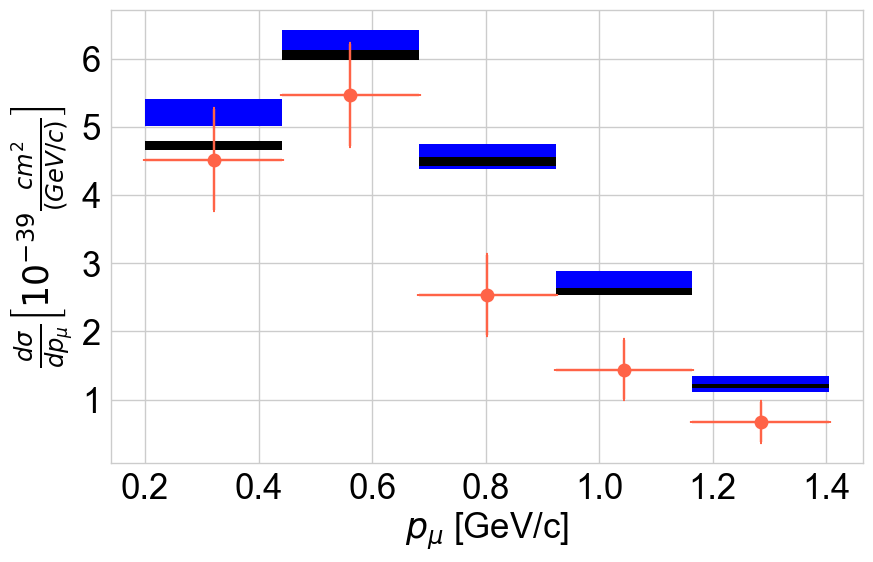

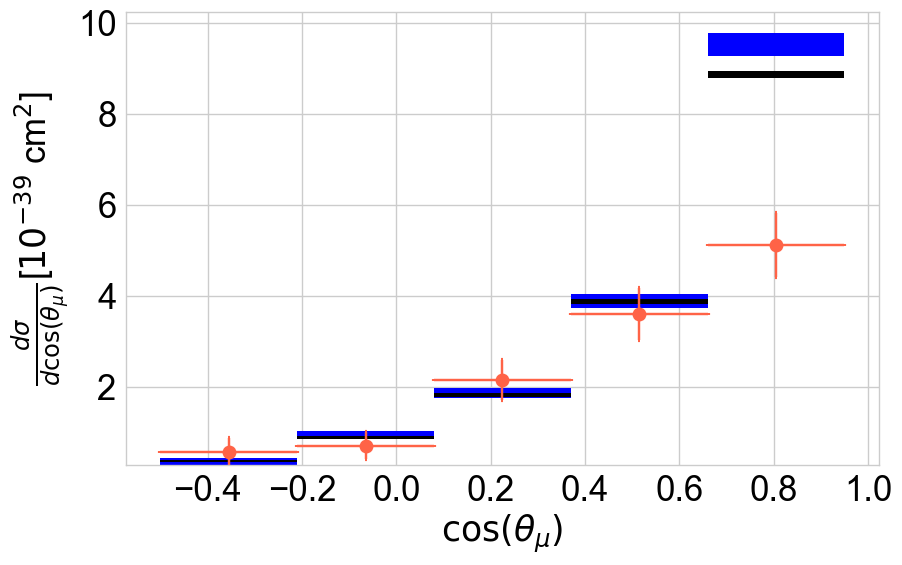

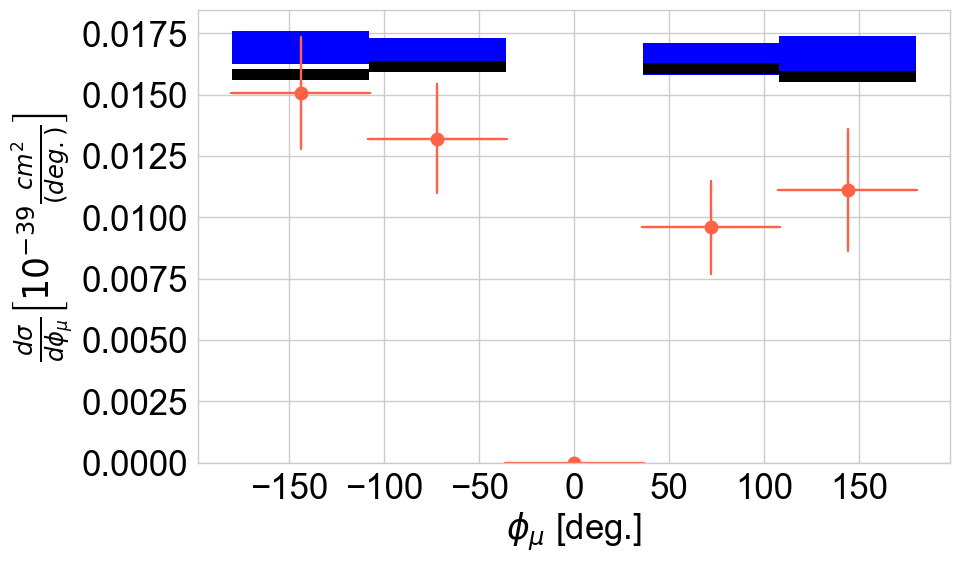

In [131]:
get_Xsec(h = h ,afro_genie_modified=afro_genie_kill_phi_0)

# “fix” $\phi_\mu \sim 0$ by a factor of 3

In [137]:
h = compute_Xsec_in_3d(beam_on=selected_beam_on,
                       beam_off=selected_beam_off,                       
                       generated_CC1p=genie_CC1p,                       
                       selected_CC1p=selected_CC1p,                       
                       overlay=selected_overlay_concat
                                      ,option = 'fix phi~0 by a factor of 3')

done.


Xsec_integrated: 4.71 +/- 0.33 e-39 cm2
mc_Xsec_integrated: 5.99 +/- 0.10 e-39 cm2



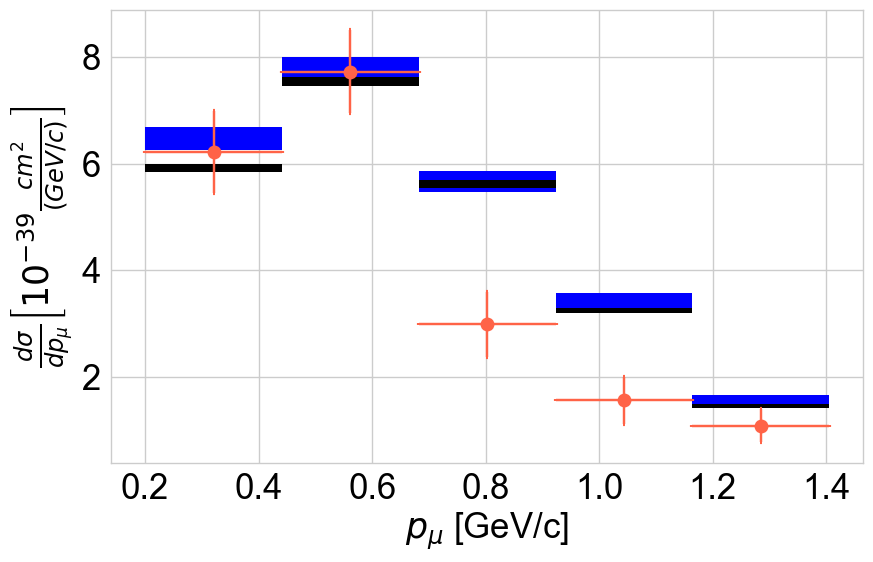

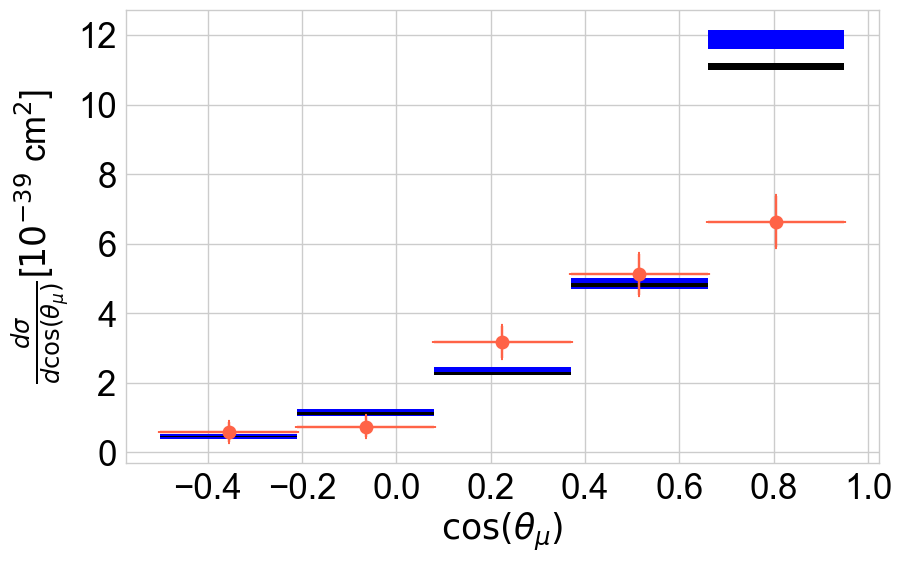

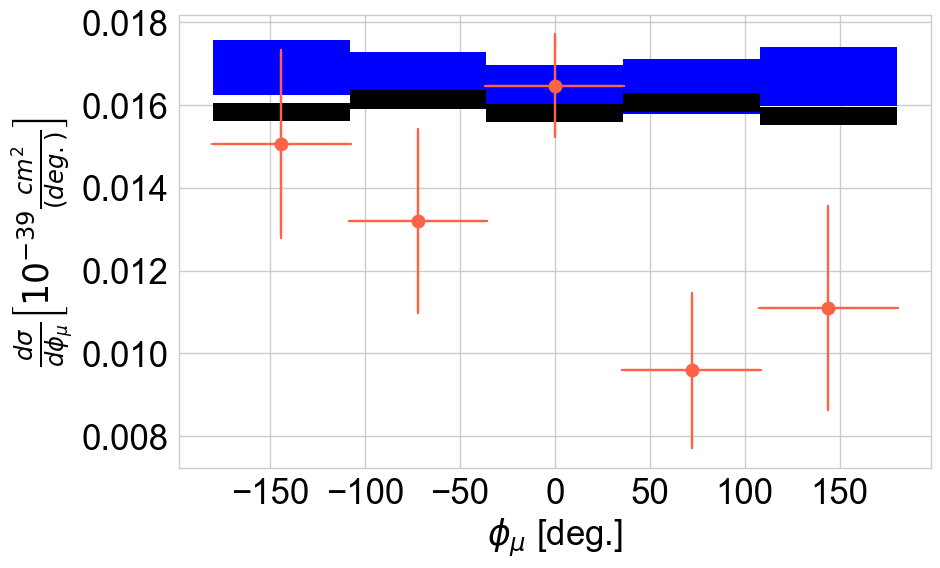

In [138]:
# afro_genie_kill_phi_0 = afro_genie_CC1p[ (180./np.pi*afro_genie_CC1p['truth_Pmu_phi'] < bins3[N3/2])
#                                         | (180./np.pi*afro_genie_CC1p['truth_Pmu_phi'] > bins3[N3/2+1])]
get_Xsec(h = h ,afro_genie_modified=afro_genie_CC1p)

# “kill” $\cos\theta_\mu \sim 1$

In [140]:
h = compute_Xsec_in_3d(beam_on=selected_beam_on,
                       beam_off=selected_beam_off,                       
                       generated_CC1p=genie_CC1p,                       
                       selected_CC1p=selected_CC1p,                       
                       overlay=selected_overlay_concat
                                      ,option = 'kill cos(theta)~1')

done.


Xsec_integrated: 2.29 +/- 0.25 e-39 cm2
mc_Xsec_integrated: 2.54 +/- 0.07 e-39 cm2



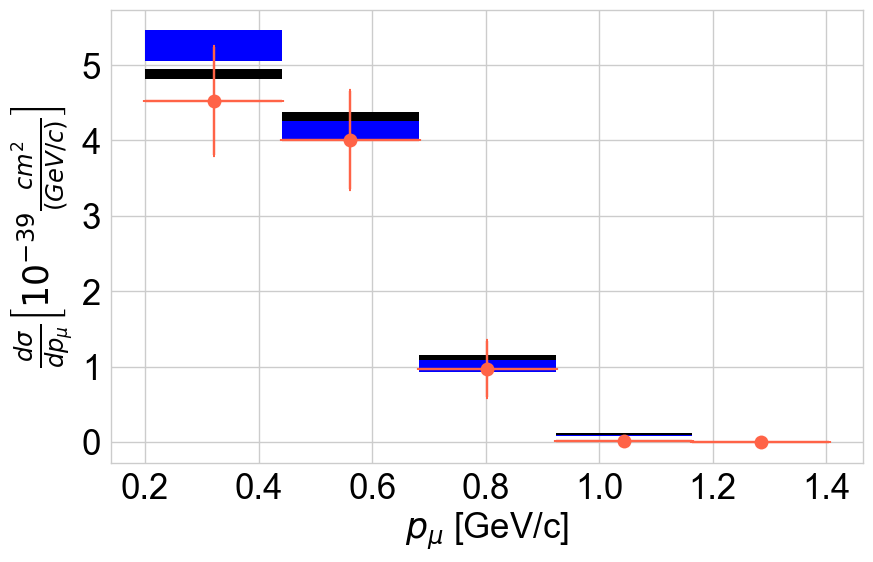

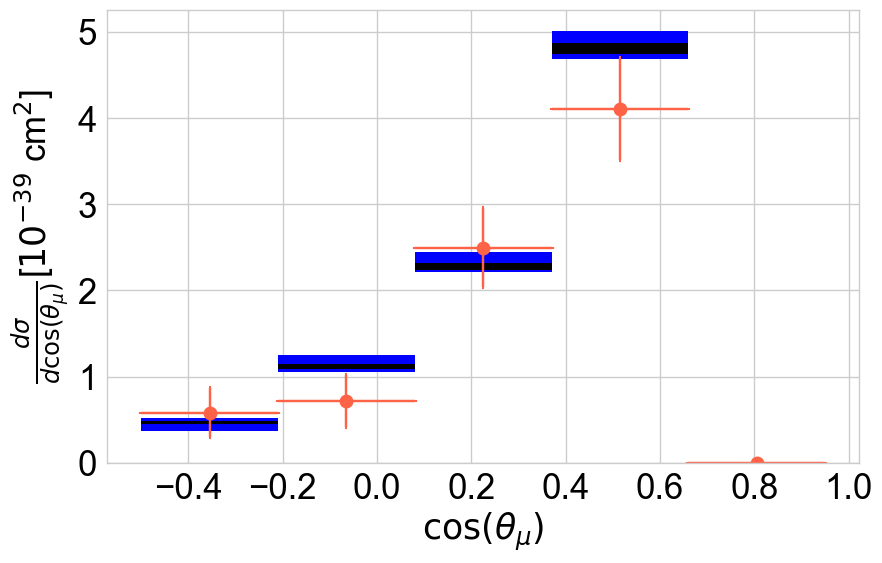

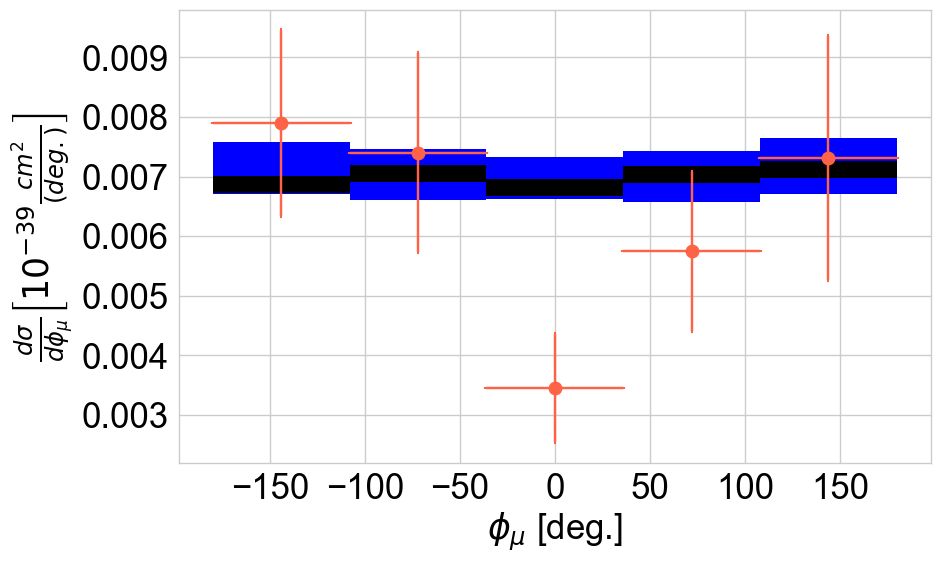

In [141]:
afro_genie_kill_cos_theta_1 = afro_genie_CC1p[ afro_genie_CC1p['truth_Pmu_cos_theta'] < bins2[N2-1] ]
get_Xsec(h = h ,afro_genie_modified=afro_genie_kill_cos_theta_1)

# “fix” $\cos\theta_\mu \sim 1$ by a factor of 2

In [143]:
h = compute_Xsec_in_3d(beam_on=selected_beam_on,
                       beam_off=selected_beam_off,                       
                       generated_CC1p=genie_CC1p,                       
                       selected_CC1p=selected_CC1p,                       
                       overlay=selected_overlay_concat
                       ,option = 'fix cos(theta)~1 by a factor of 2')

done.


Xsec_integrated: 5.55 +/- 0.33 e-39 cm2
mc_Xsec_integrated: 5.99 +/- 0.10 e-39 cm2



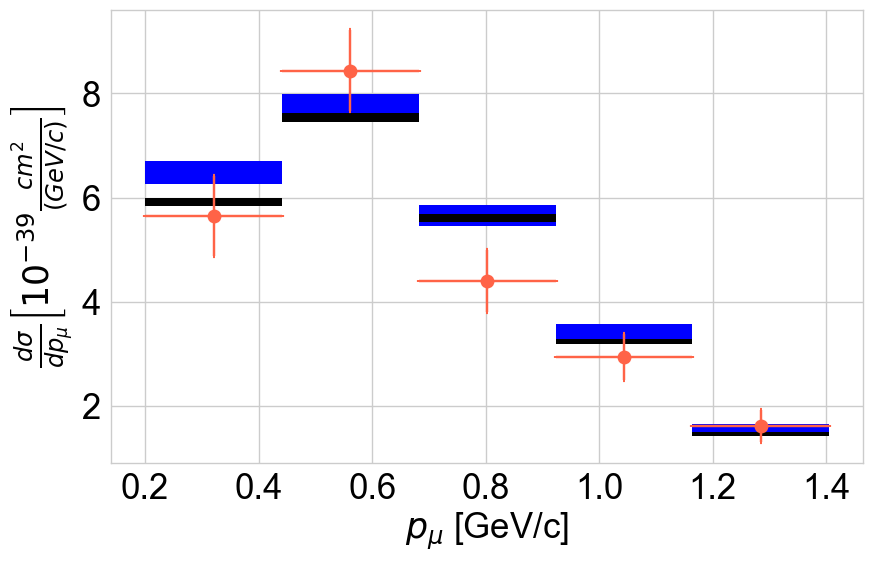

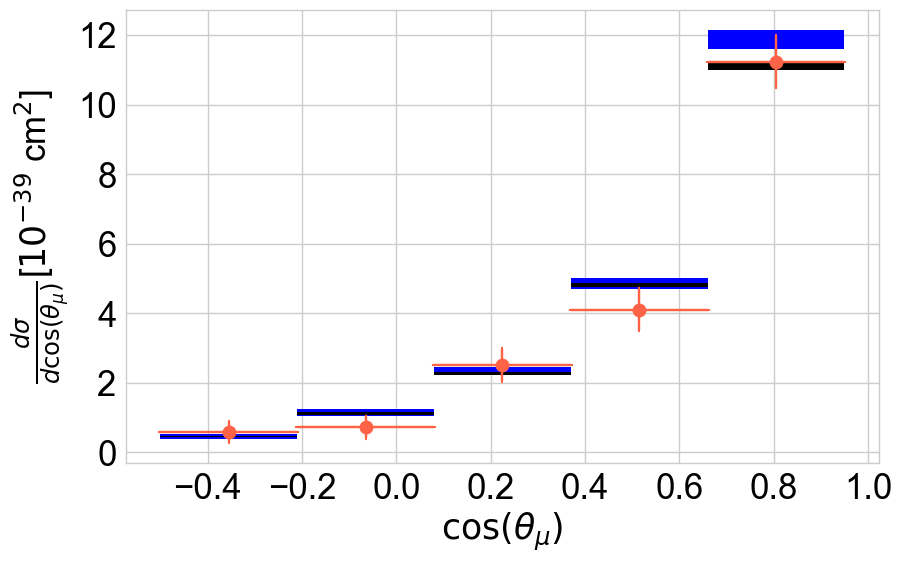

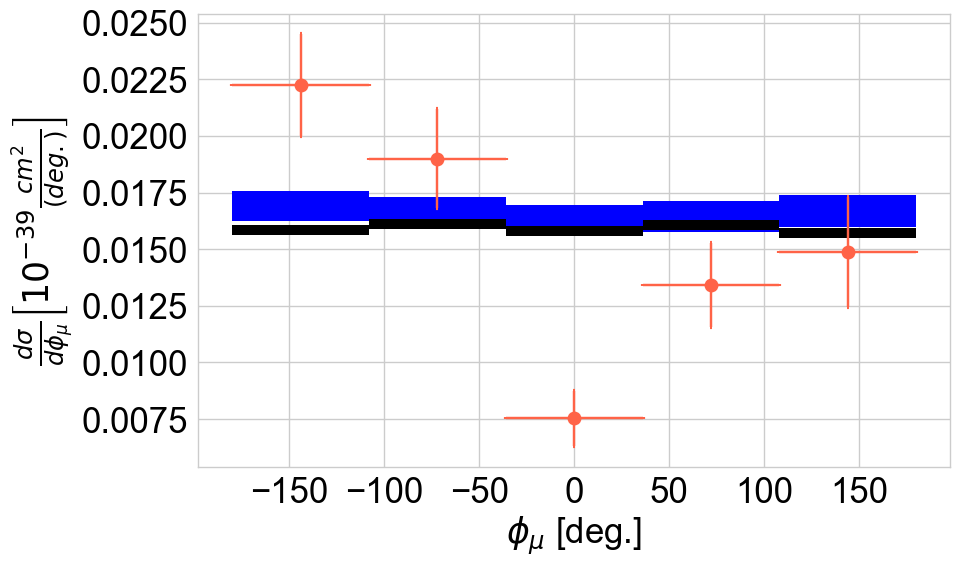

In [144]:
get_Xsec(h = h ,afro_genie_modified=afro_genie_CC1p)

# “kill” $\phi_\mu \sim 0$ and $\cos\theta_\mu \sim 1$

In [146]:
h = compute_Xsec_in_3d(beam_on=selected_beam_on,
                       beam_off=selected_beam_off,                       
                       generated_CC1p=genie_CC1p,                       
                       selected_CC1p=selected_CC1p,                       
                       overlay=selected_overlay_concat     
                       ,option = 'kill cos(theta)~1 and phi~0')

done.


Xsec_integrated: 2.04 +/- 0.24 e-39 cm2
mc_Xsec_integrated: 2.04 +/- 0.06 e-39 cm2



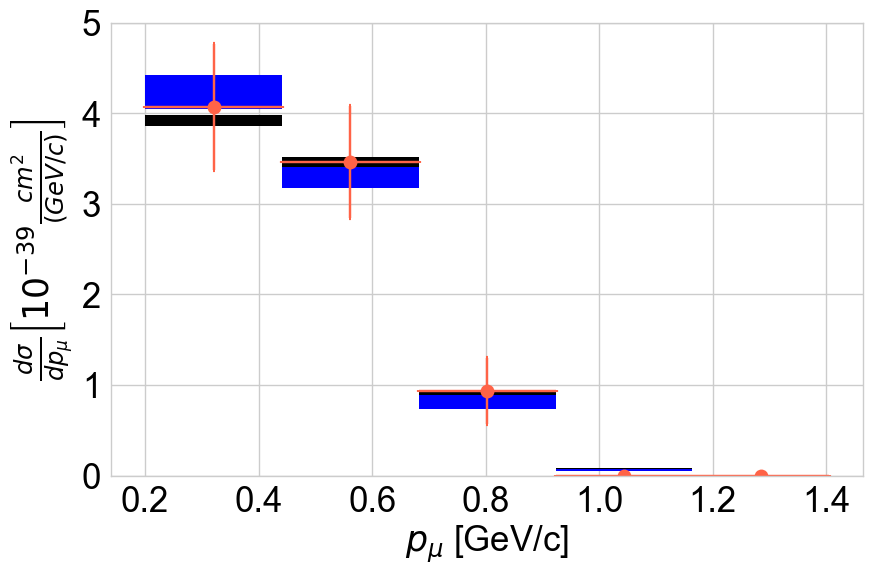

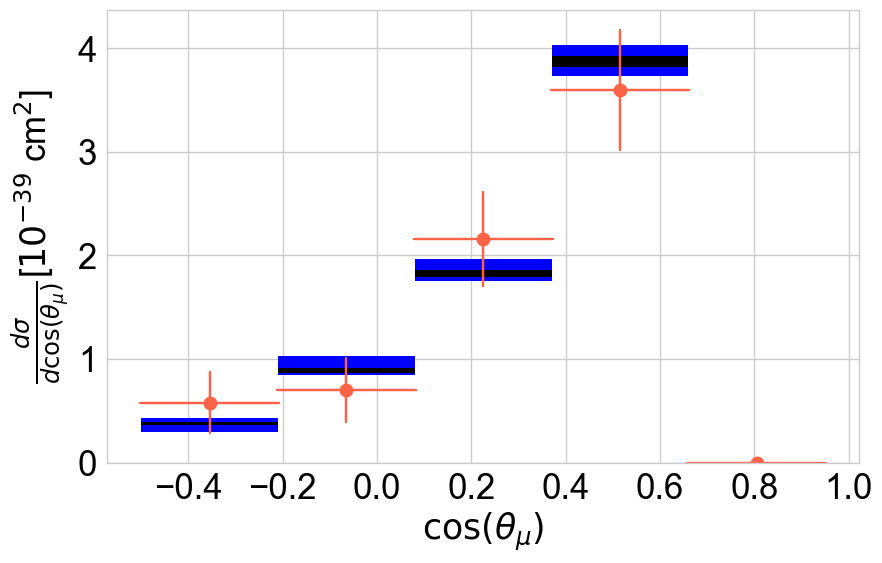

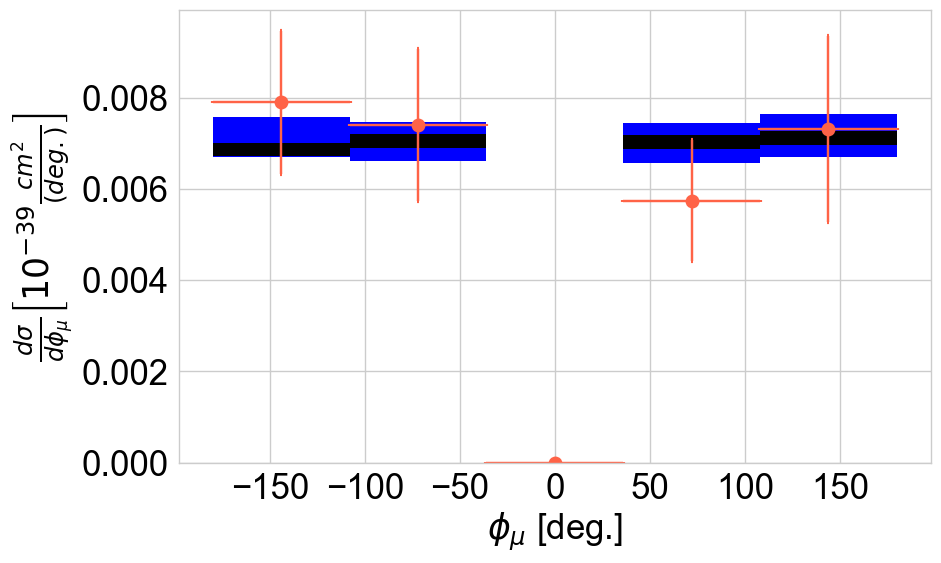

In [147]:
afro_genie_kill_cos_theta_1_phi_0 = afro_genie_CC1p[( (180./np.pi*afro_genie_CC1p['truth_Pmu_phi'] < bins3[N3/2])                                 
                                                     | (180./np.pi*afro_genie_CC1p['truth_Pmu_phi'] > bins3[N3/2+1]))
                                                    &
                                                    (afro_genie_CC1p['truth_Pmu_cos_theta'] < bins2[N2-1]) ]
get_Xsec(h = h ,afro_genie_modified=afro_genie_kill_cos_theta_1_phi_0)

# “fix” $\phi_\mu \sim 0$ by a factor 2 and $\cos\theta_\mu \sim 1$ by a factor of 2

In [8]:
h = compute_Xsec_in_3d(beam_on=selected_beam_on,
                       beam_off=selected_beam_off,                       
                       generated_CC1p=genie_CC1p,                       
                       selected_CC1p=selected_CC1p,                       
                       overlay=selected_overlay_concat
                       ,option = 'fix cos(theta)~1 by a factor of 2 and phi~0 by a factor 2')

done.


Xsec_integrated: 6.09 +/- 0.33 e-39 cm2
mc_Xsec_integrated: 5.99 +/- 0.10 e-39 cm2



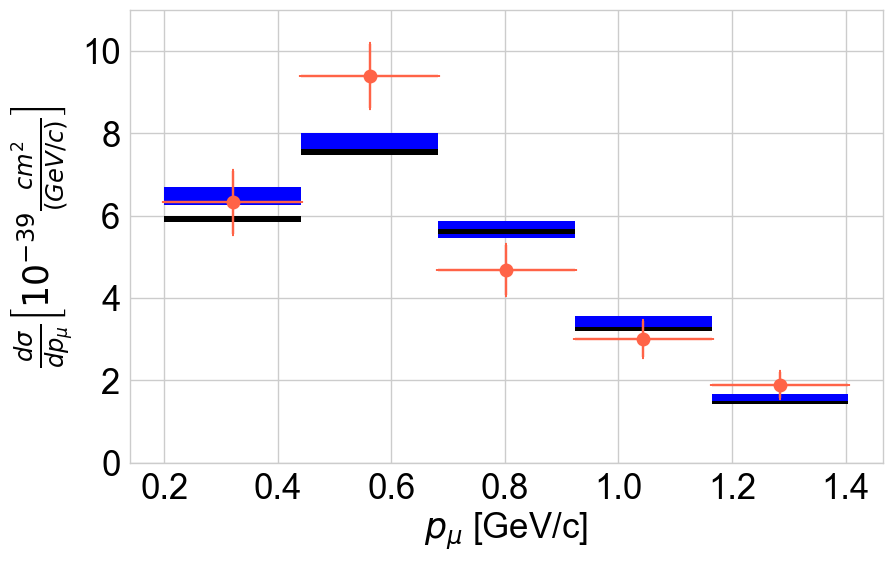

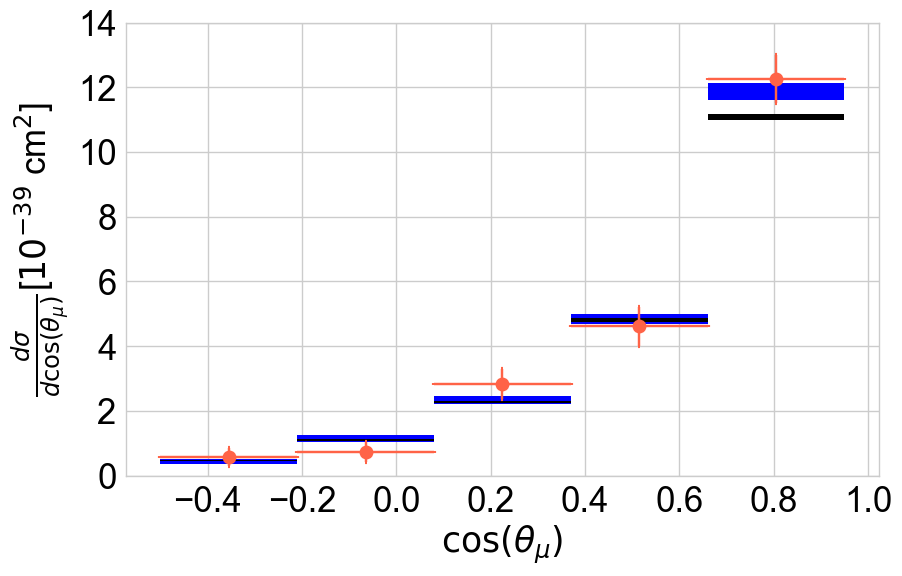

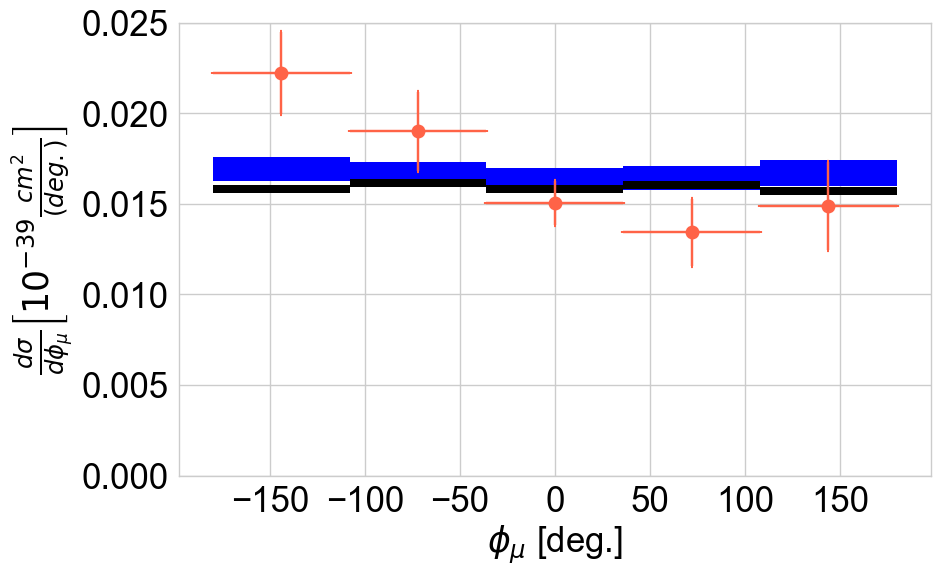

In [15]:
get_Xsec(h = h ,afro_genie_modified=afro_genie_CC1p
         ,ylim_P=(0,11),ylim_cos_theta=(0,14),ylim_phi=(0,0.025))